In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', palette='colorblind')
plt.rcParams['figure.figsize'] = (12,9)

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import pickle

In [2]:
df_segmentation = pd.read_csv('/content/segmentation_data.csv', index_col= 0)

## 1. Data Exploration

In [3]:
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


**Correlation Estimate**

In [5]:
df_segmentation.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


**Visualise Raw Data**

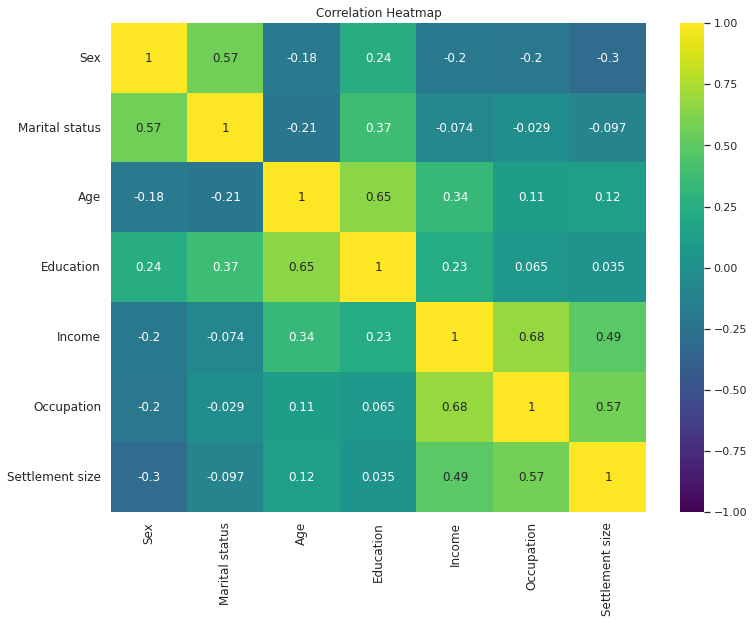

In [6]:
s = sns.heatmap(df_segmentation.corr(),
                annot = True,
                cmap = 'viridis',
                vmin = -1,
                vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

Text(0.5, 1.0, 'Correlation between Age and income')

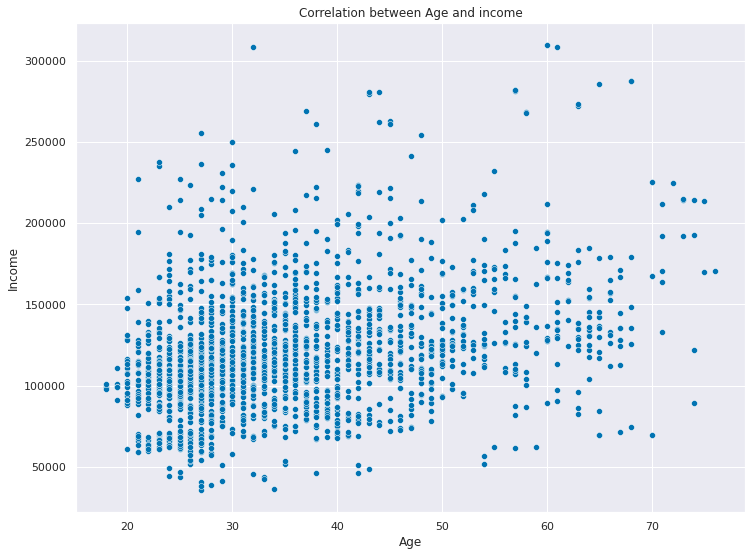

In [7]:
sns.scatterplot(x=df_segmentation.iloc[:,2], y=df_segmentation.iloc[:,4])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Correlation between Age and income')

## 2. Standardisation

For all our features to have equal weight, we standardize our data.

In [8]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

## 3. Hierarchical Clustering

We use hierarchical clustering on our data first.

In [9]:
hier_clust = linkage(segmentation_std, method = 'ward')

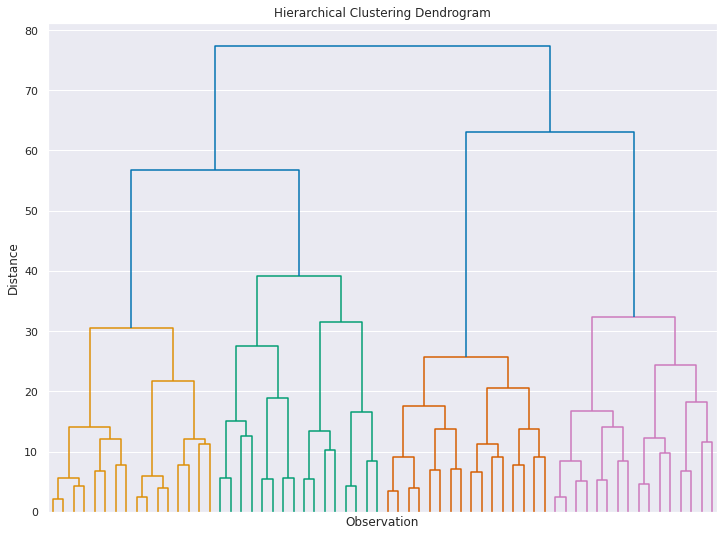

In [10]:
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observation')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.show()

Using a dendrogram, we can visualize that there are likely four different clusters of customers. Let's confirm using K-means.

## 4. K-Means Clustering

In [11]:
wcss = [] #sum of squares of the distances of each data point in all clusters to their respective centroids
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init= 'k-means++', random_state = 11)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

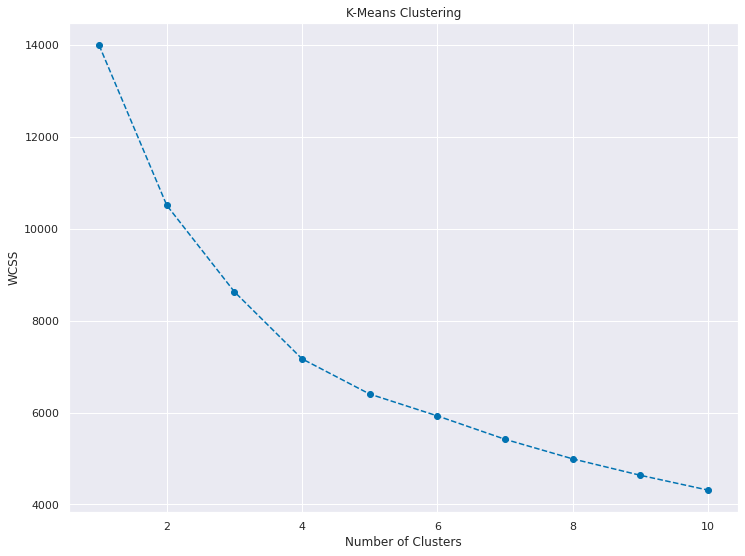

In [12]:
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means Clustering')
plt.show()

Using the elbow method we can identify 4 clusters.

This confirms the results from hierarchical clustering.

In [13]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 11)

In [14]:
kmeans.fit(segmentation_std)

KMeans(n_clusters=4, random_state=11)

We create a new data frame with the four clusters and group by them to get the mean values for each cluster.

In [15]:
df_segm_kmeans = df_segmentation.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [16]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695
3,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266


In [17]:
#Calculate the size of each segment
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means', 'Sex']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

In [18]:
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
3,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315


In [26]:
df_segm_analysis.rename({0:'weathly_city_dwellers',
                         1:'fewer_opportunities',
                         2:'young_standard',
                         3:'high_education_experienced'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
weathly_city_dwellers,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
fewer_opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
young_standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
high_education_experienced,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315


In [28]:
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'weathly_city_dwellers',
                         1:'fewer_opportunities',
                         2:'young_standard',
                         3:'high_education_experienced'})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


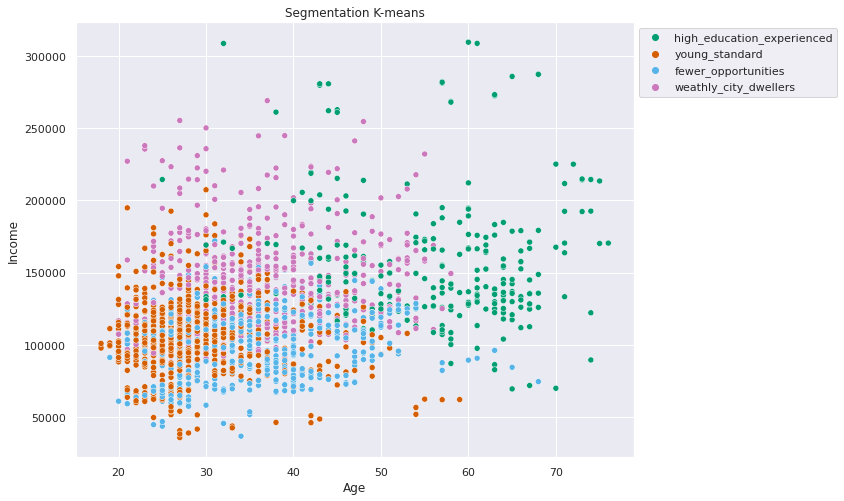

In [29]:
x_axis = df_segm_kmeans['Age']
y_axis = df_segm_kmeans['Income']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue =df_segm_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.legend(bbox_to_anchor=(1, 1))

## 5. Principal Component Analysis (PCA)

Employ PCA to find a smaller subset of the data that still explains our segments.

**Dimensionality Reduction**

In [30]:
pca = PCA()

In [31]:
pca.fit(segmentation_std)

PCA()

In [33]:
pca.explained_variance_ratio_.cumsum()

array([0.35696328, 0.61947251, 0.80768365, 0.88326115, 0.94042627,
       0.97997421, 1.        ])

88% of the data is explained with 4 instead of 7 features.

Text(0, 0.5, 'Cumulative Explained Variance')

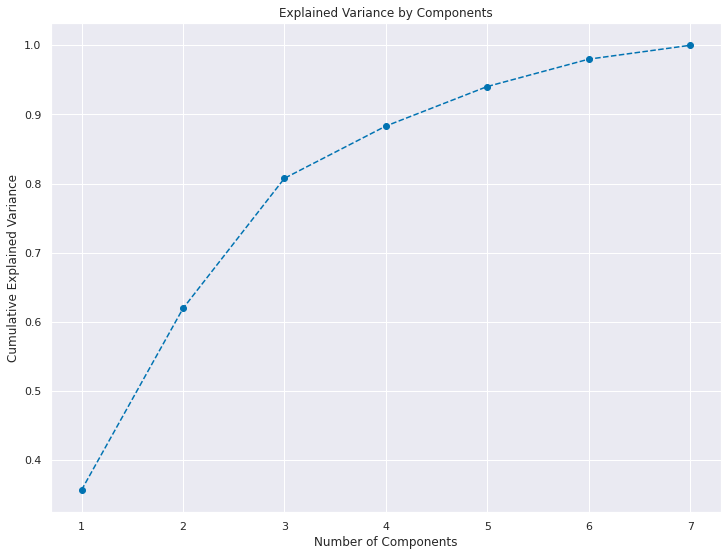

In [34]:
plt.figure(figsize= (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [35]:
pca = PCA(n_components = 4)

In [36]:
pca.fit(segmentation_std)

PCA(n_components=4)

###PCA Results

In [37]:
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503],
       [-0.31560091,  0.28045392, -0.00950602,  0.18147643, -0.48260023,
        -0.28169039,  0.69026455]])

In [39]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_segmentation.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3', 'Component 4'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685
Component 4,-0.315601,0.280454,-0.009506,0.181476,-0.482600,-0.281690,0.690265


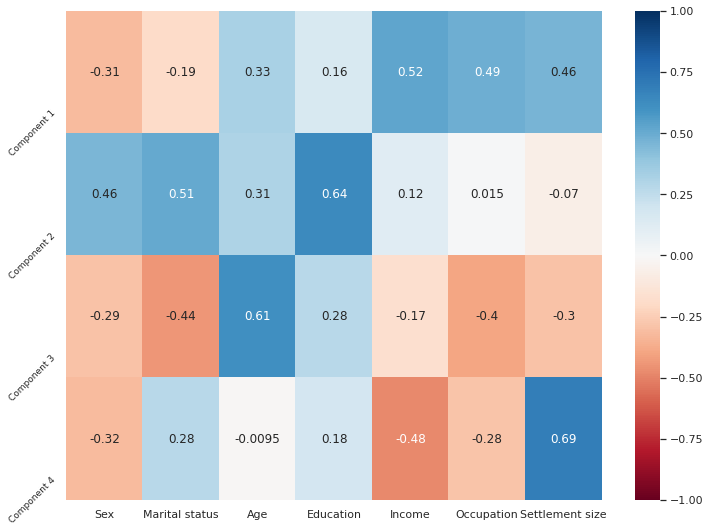

In [47]:
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([1 , 2 , 3, 4],
           ['Component 1', 'Component 2', 'Component 3', 'Component 4'],
           rotation = 45,
           fontsize = 9);

# Heat Map for Principal Components against original features.

In [48]:
pca.transform(segmentation_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ,  1.21779432],
       [ 0.34493528,  0.59814564, -2.21160279,  0.54838542],
       [-0.65106267, -0.68009318,  2.2804186 ,  0.12067518],
       ...,
       [-1.45229829, -2.23593665,  0.89657125, -0.13177412],
       [-2.24145254,  0.62710847, -0.53045631, -0.04260559],
       [-1.86688505, -2.45467234,  0.66262172,  0.10089556]])

In [51]:
scores_pca = pca.transform(segmentation_std)

##K-Means Clustering with PCA

Let's run a new K-means model with our PCA features instead of all of them.

In [52]:
wcss = []
for i in range(1,11):
  kmeans_pca = KMeans(n_clusters = i, init= 'k-means++', random_state = 11)
  kmeans_pca.fit(scores_pca)
  wcss.append(kmeans_pca.inertia_)

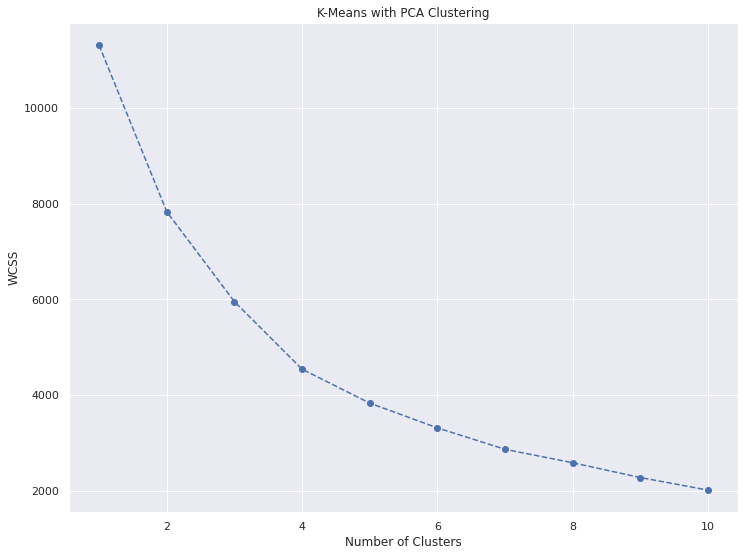

In [ ]:
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means with PCA Clustering')
plt.show()

Four clusters still looks like the best number of segments.

In [54]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state = 11)

In [55]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=11)

###K-Means clustering with PCA results

In [56]:
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [57]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,0,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,1.217794,0
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0.548385,2
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,0.120675,3
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,-0.510753,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,-0.231808,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,-0.945916,3
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,-0.736766,2
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,-0.131774,3
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,-0.042606,2


In [58]:
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,0,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,,
0,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,0.093869
1,0.026178,0.178010,35.624782,0.734729,140950.319372,1.267016,1.520070,1.381089,-1.044848,-0.273292,0.211736
2,0.905045,0.986647,28.873887,1.063798,107576.228487,0.672107,0.439169,-1.122432,0.733291,-0.797918,-0.019662
3,0.319018,0.089980,35.259714,0.768916,95850.155419,0.296524,0.038855,-0.987777,-0.882022,0.965476,-0.271684


In [59]:
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA', 'Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'standard',
                                                          1:'career focused',
                                                          2: 'fewer opportunities',
                                                          3: 'well-off'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,0,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,,
standard,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,0.093869,264,0.1320
career focused,0.026178,0.178010,35.624782,0.734729,140950.319372,1.267016,1.520070,1.381089,-1.044848,-0.273292,0.211736,573,0.2865
fewer opportunities,0.905045,0.986647,28.873887,1.063798,107576.228487,0.672107,0.439169,-1.122432,0.733291,-0.797918,-0.019662,674,0.3370
well-off,0.319018,0.089980,35.259714,0.768916,95850.155419,0.296524,0.038855,-0.987777,-0.882022,0.965476,-0.271684,489,0.2445


In [60]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'weathly_city_dwellers',
                         1:'fewer_opportunities',
                         2:'young_standard',
                         3:'high_education_experienced'})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Clusters by PCA Components')

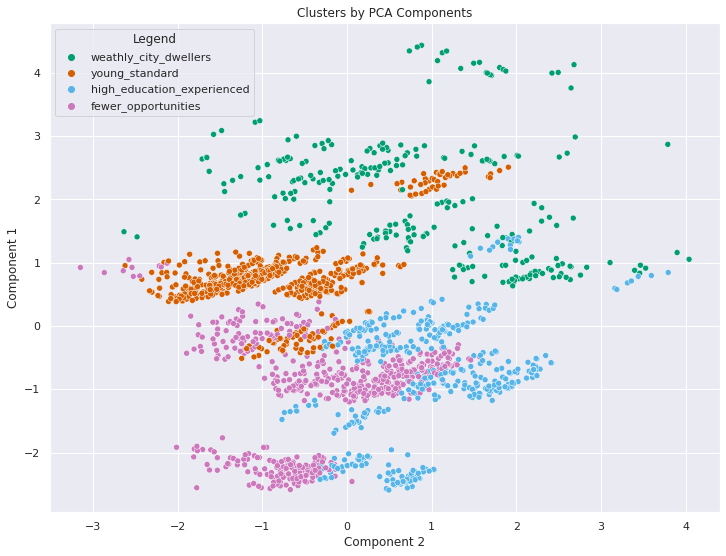

In [63]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
